[Reference](https://riteshshergill.medium.com/time-series-forecasting-in-the-year-2024-d80a4a21abf1)

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch import optim
import joblib

# Read data

In [38]:
# Load the data
data = pd.read_csv('https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv')

# EDA of the Dataset

In [39]:
# Convert date column to datetime
data['date'] = pd.to_datetime(data['date'])

In [40]:
# Display basic statistics
print(data.describe())

                      date          HUFL          HULL          MUFL  \
count                17420  17420.000000  17420.000000  17420.000000   
mean   2017-06-28 21:30:00      7.375141      2.242242      4.300239   
min    2016-07-01 00:00:00    -22.705999     -4.756000    -25.087999   
25%    2016-12-29 10:45:00      5.827000      0.737000      3.296000   
50%    2017-06-28 21:30:00      8.774000      2.210000      5.970000   
75%    2017-12-27 08:15:00     11.788000      3.684000      8.635000   
max    2018-06-26 19:00:00     23.643999     10.114000     17.341000   
std                    NaN      7.067744      2.042342      6.826978   

               MULL          LUFL          LULL            OT  
count  17420.000000  17420.000000  17420.000000  17420.000000  
mean       0.881568      3.066062      0.856932     13.324672  
min       -5.934000     -1.188000     -1.371000     -4.080000  
25%       -0.284000      2.315000      0.670000      6.964000  
50%        0.959000      2.8330

          date      HUFL      HULL      MUFL      MULL      LUFL      LULL  \
date  1.000000 -0.166374  0.036580 -0.198914 -0.001046  0.162609  0.130340   
HUFL -0.166374  1.000000  0.114672  0.987355  0.066002  0.291418  0.023606   
HULL  0.036580  0.114672  1.000000  0.068817  0.930491  0.259487  0.377641   
MUFL -0.198914  0.987355  0.068817  1.000000  0.046266  0.177491 -0.046519   
MULL -0.001046  0.066002  0.930491  0.046266  1.000000  0.128607  0.069419   
LUFL  0.162609  0.291418  0.259487  0.177491  0.128607  1.000000  0.334563   
LULL  0.130340  0.023606  0.377641 -0.046519  0.069419  0.334563  1.000000   
OT   -0.623583  0.059916  0.224354  0.050854  0.220004  0.118836  0.067455   

            OT  
date -0.623583  
HUFL  0.059916  
HULL  0.224354  
MUFL  0.050854  
MULL  0.220004  
LUFL  0.118836  
LULL  0.067455  
OT    1.000000  


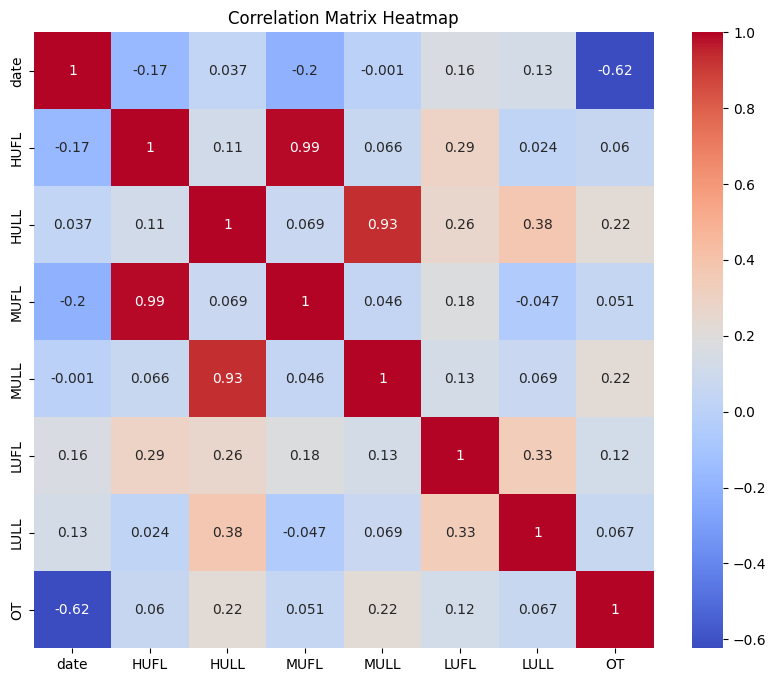

In [41]:
# Display the correlation matrix
corr_matrix = data.corr()
print(corr_matrix)

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

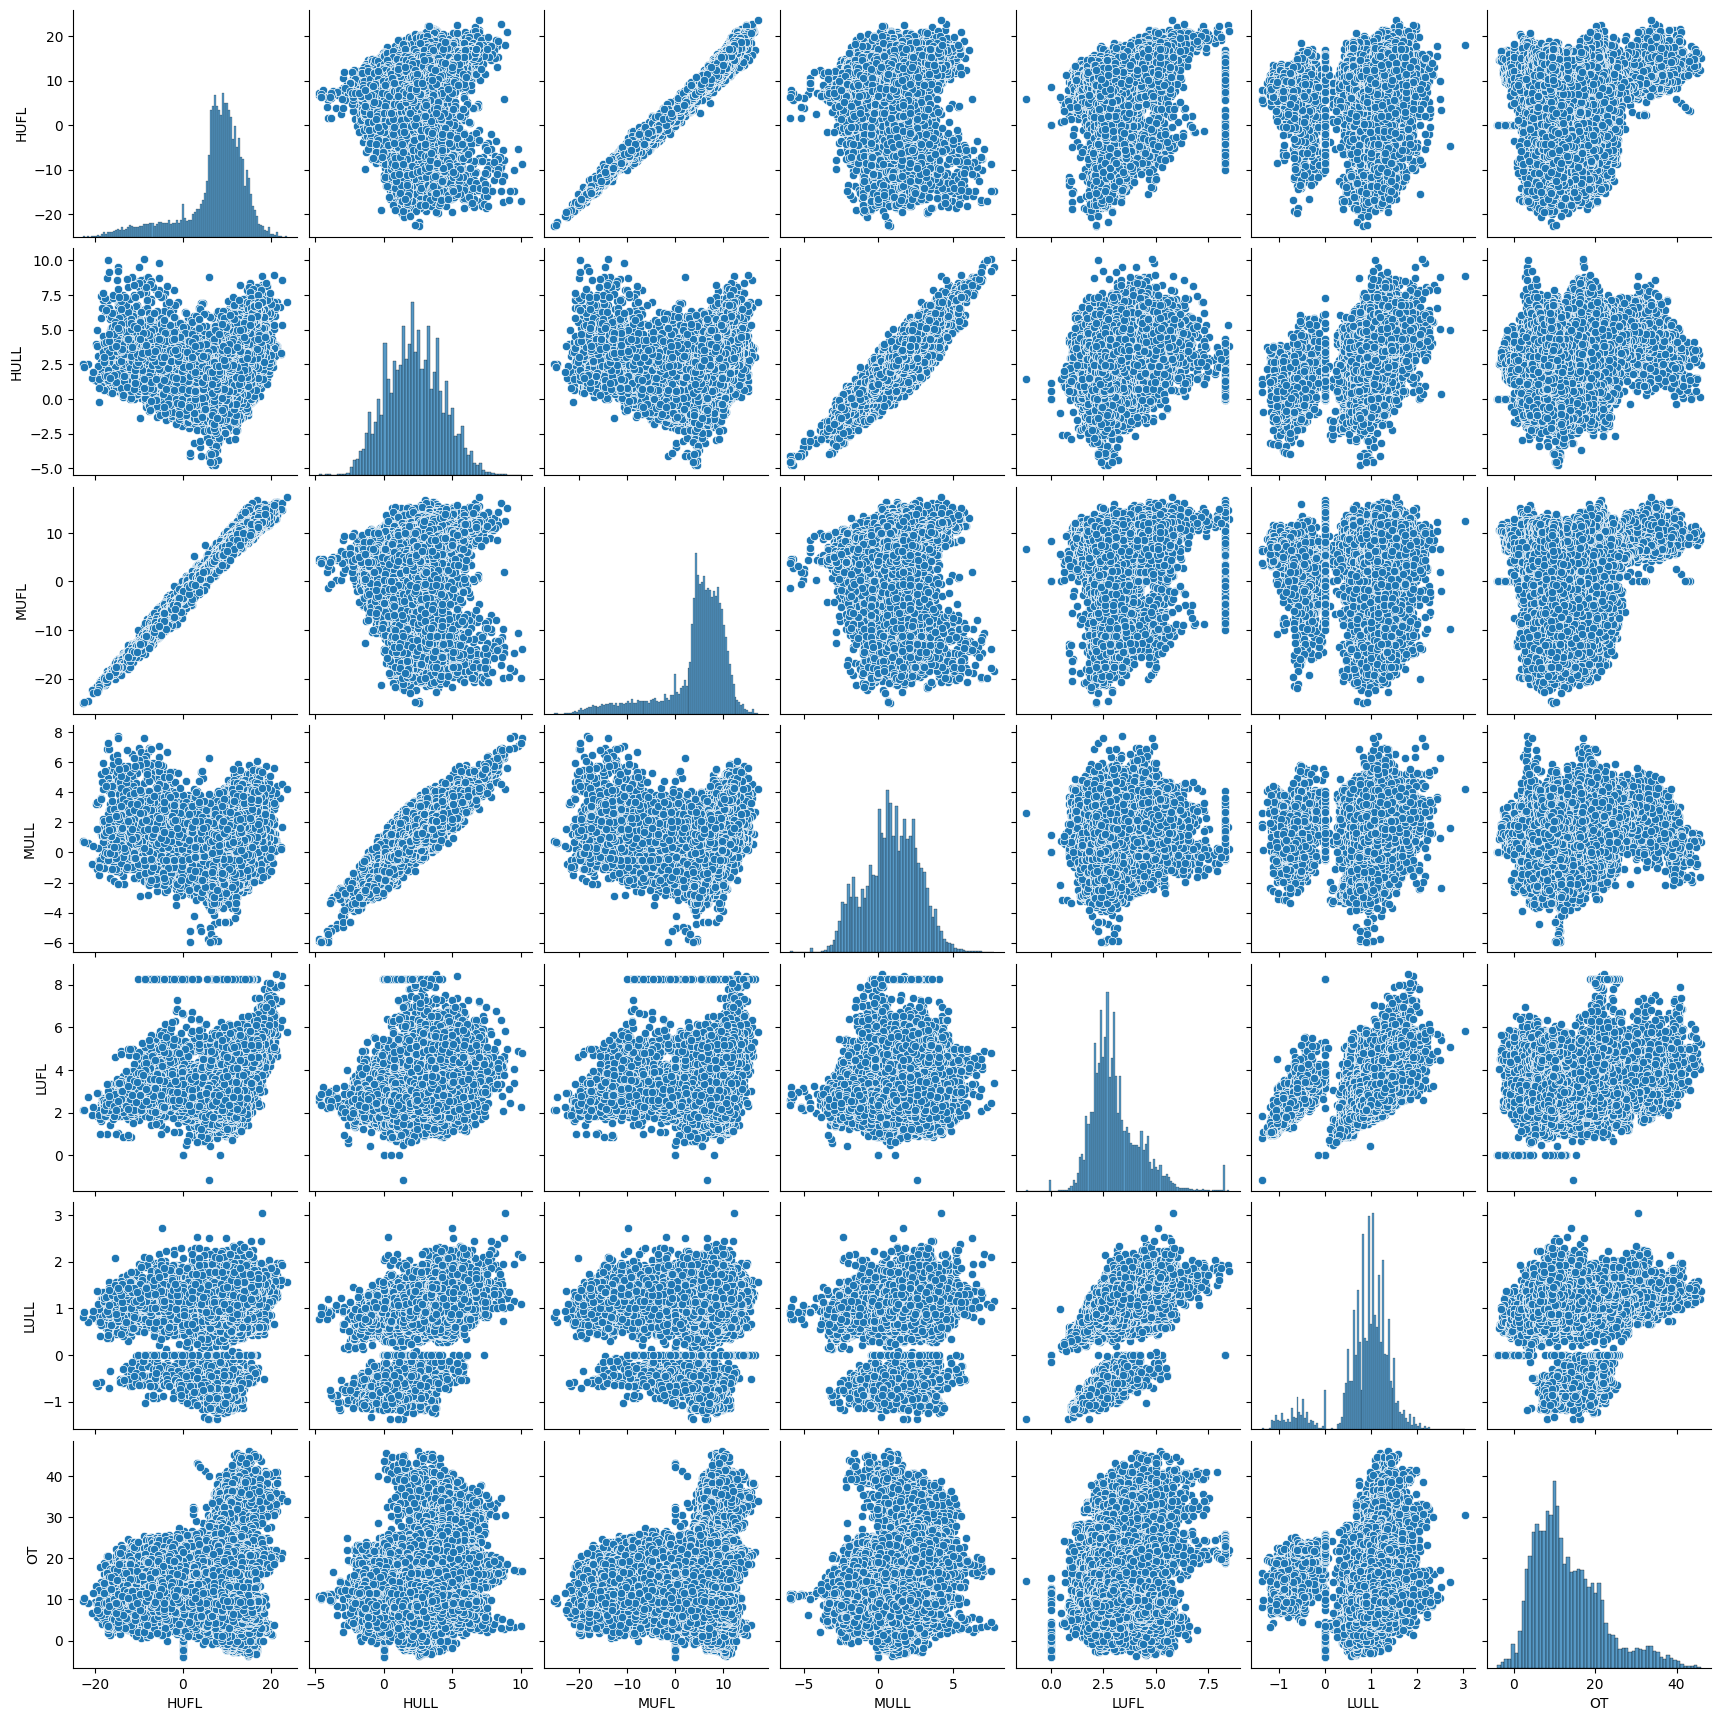

In [42]:
# Plot pairplot to see the relationships and distribution of the variables
sns.pairplot(data.drop(columns=['date']))
plt.show()

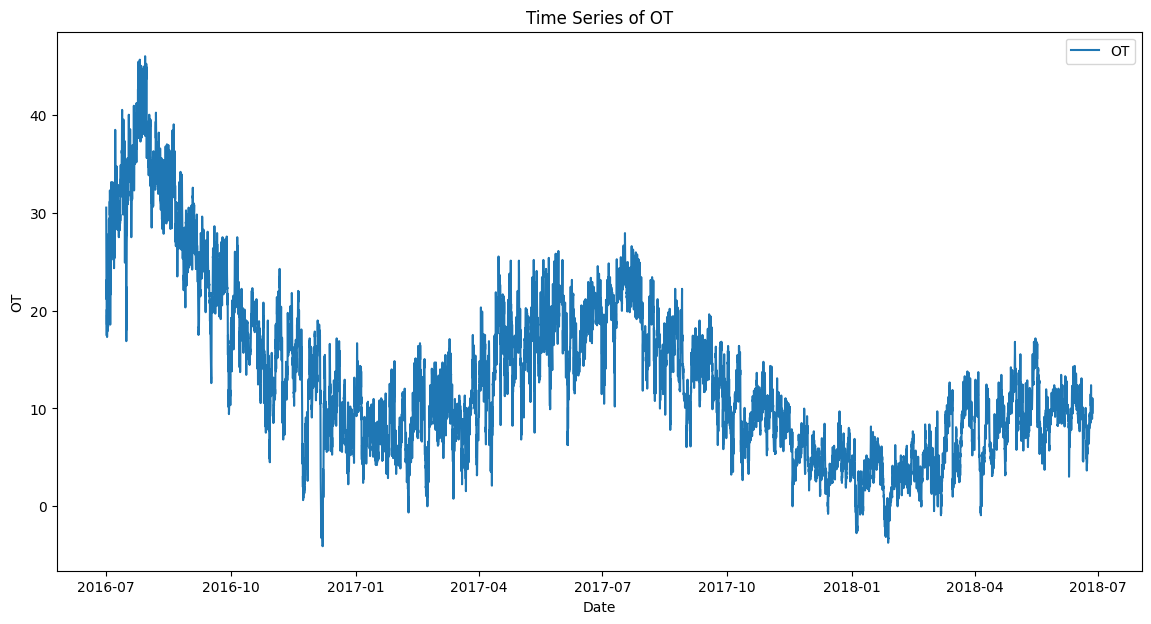

In [43]:
# Plot time series for OT (Oil Temperature)
plt.figure(figsize=(14, 7))
plt.plot(data['date'], data['OT'], label='OT')
plt.xlabel('Date')
plt.ylabel('OT')
plt.title('Time Series of OT')
plt.legend()
plt.show()

# Data Preparation

In [44]:
# Separate features and target, excluding the date column
features = data.drop(columns=['date', 'OT'])
target = data['OT']

In [45]:
# Normalize the features and target (OT column)
scaler_features = MinMaxScaler()
scaled_features = scaler_features.fit_transform(features)

# Scales target data to a range between 0 and 1
scaler_target = MinMaxScaler()
scaled_target = scaler_target.fit_transform(target.values.reshape(-1, 1))

# Combine scaled features and target
scaled_data = np.hstack((scaled_features, scaled_target))

In [46]:
# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        # feature set
        X.append(data[i:i + seq_length, :-1])
        # target set
        y.append(data[i + seq_length, -1])
    return np.array(X), np.array(y)

# Length of the sequence for LSTM for monthly patterns but the sequence length
# depends on the data domain and varies in order to capture seasonality trends
# in the data also if any exist
SEQ_LENGTH = 30
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Split into train and test sets
train_size = int(len(X) * 0.9)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# The Model Definition

In [47]:
# Define the LSTM model
class LSTMModel(nn.Module):
    #added dropout for regularization
    def __init__(self, input_size, hidden_layer_size=50, num_layers=1, dropout=0.3, output_size=1):
        super(LSTMModel, self).__init__()
        # lstm hidden layer
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        # linear hidden layer
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        x = lstm_out[:, -1, :]  # Use only the last output of the LSTM
        x = self.linear(x)
        return x

# Defining Hyperparameters

In [48]:
# Instantiate the model, define the loss function and the optimizer
input_size = X_train.shape[2] # no of features in the dataset for input size
model = LSTMModel(input_size)
loss_function = nn.MSELoss() # compute Mean Squared Error loss

# optimization algorithm that updates model parameters to minimize the loss function which is the MSE
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Parameters to train the model
epochs = 10
batch_size = 64
losses = []

# load the training data
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


# Training the Model

Epoch 1, Loss: 0.033106165052372585


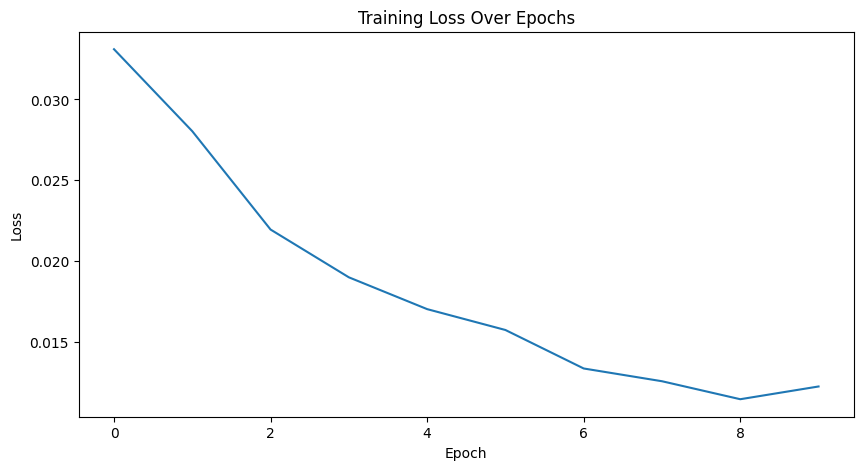

In [49]:
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_function(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    losses.append(epoch_loss)
    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}, Loss: {epoch_loss}')

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

# Training Results

Test Loss: 41.741661071777344


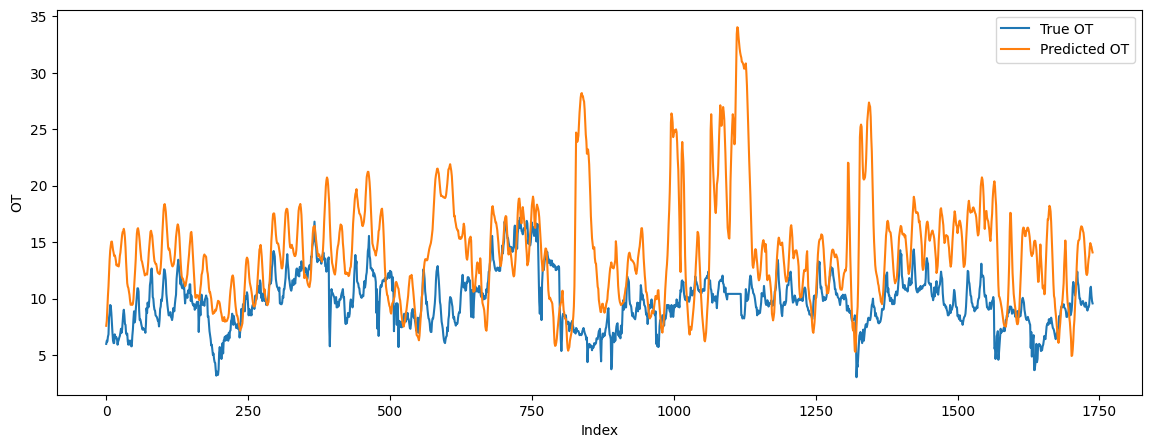

In [51]:
# Put the model into evaluation mode to get inferences
model.eval()
with torch.no_grad():
    y_pred = model(X_test)

# Reshape predictions for inverse transformation
y_pred_scaled = y_pred.numpy().reshape(-1, 1)
y_test_scaled = y_test.numpy().reshape(-1, 1)

# Load the fitted scaler for target
# scaler_target = joblib.load('scaler_target.pkl')

# Perform inverse transformation on the target values only
# Since we had normalized the data initially, we must revert to normal values for predictions
y_pred_inverse = scaler_target.inverse_transform(y_pred_scaled)
y_test_inverse = scaler_target.inverse_transform(y_test_scaled)

# Calculate test loss which is the MSE
test_loss = np.mean((y_pred_inverse - y_test_inverse) ** 2)
print(f'Test Loss: {test_loss}')

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(range(len(y_test_inverse)), y_test_inverse, label='True OT')
plt.plot(range(len(y_test_inverse)), y_pred_inverse, label='Predicted OT')
plt.xlabel('Index')
plt.ylabel('OT')
plt.legend()
plt.show()